# Build an AutoEncoder from scratch using PyTorch

In [9]:
import torch, torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Prepare MNIST Dataset

### Load MNSIT Dataset

In [5]:
!mkdir mnist

In [10]:
mnist = datasets.MNIST('./mnist/', download=True,
                      transform= torchvision.transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Lambda(lambda tensor: tensor.flatten())
                      ])
        )

In [45]:
def to_numpy(tensor: torch.Tensor, reshape=True):
  num = tensor.detach().cpu().numpy()
  return num.reshape(28, 28) if reshape else num

### Visualize MNSIT

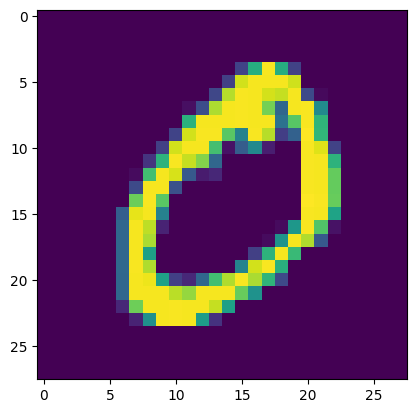

In [46]:
plt.imshow(to_numpy(mnist[1][0]))

### split Dataset

In [16]:
train_data , test_data = random_split(mnist, [50000, 10000])

In [40]:
train_loader = DataLoader(train_data, batch_size=10000, shuffle=True)

In [21]:
test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)

## Build The AutoEncoder Model

In [60]:
class AutoEncoder(nn.Module):

    def __init__(self, ) -> None:
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )

        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28)
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        out = self.encoder(input)
        return self.decoder(out)

In [61]:
# create an instance of AutoEncoder class

model = AutoEncoder().to(device)

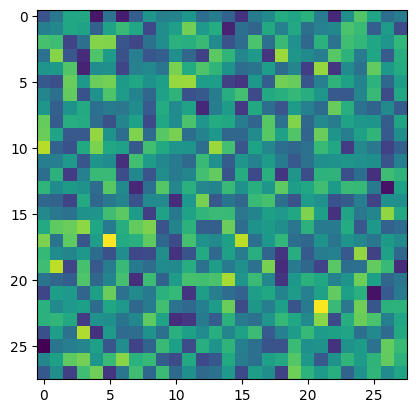

In [62]:
# genrate random image

out_img = model(mnist[1][0].to(device))

plt.imshow(to_numpy(out_img))

In [63]:
criterion = nn.MSELoss()

In [75]:
opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.99)

## Train Loop

Iteration: 1 | loss: 0.0562129020690918


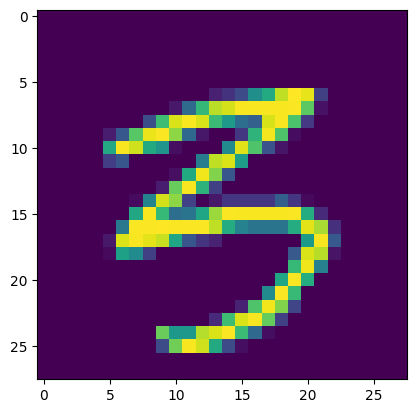

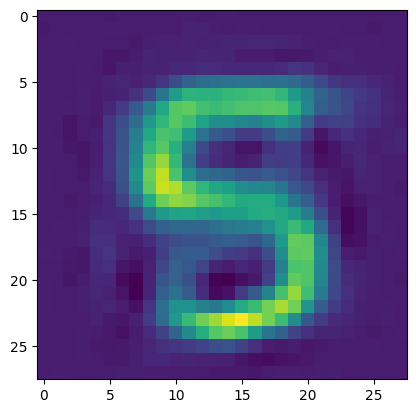

Iteration: 5000 | loss: 0.0932048112154007


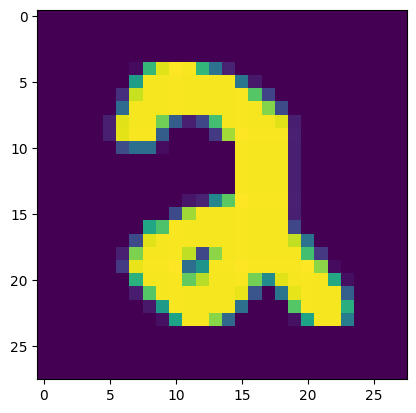

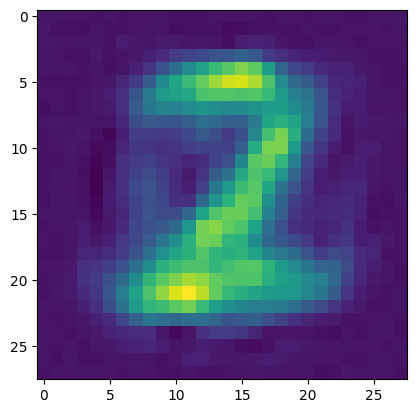

Iteration: 10000 | loss: 0.03859047591686249


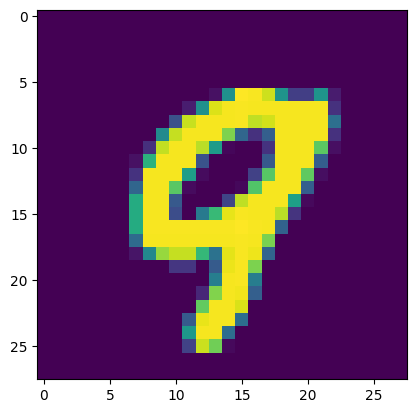

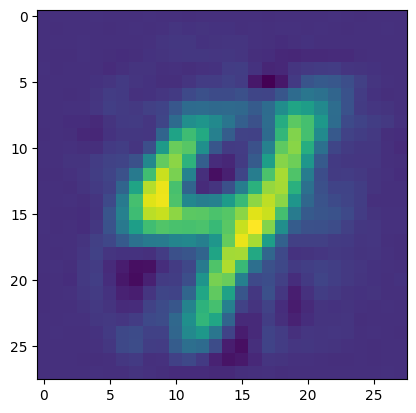

Iteration: 15000 | loss: 0.02307870425283909


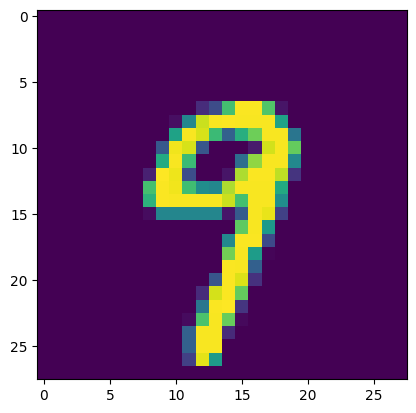

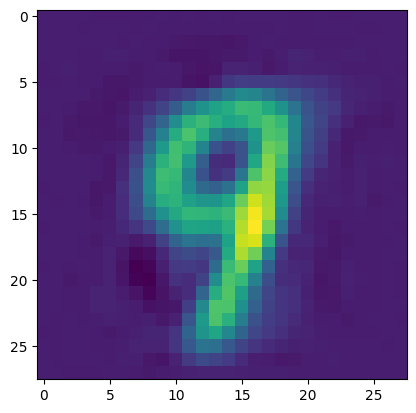

Iteration: 20000 | loss: 0.052120111882686615


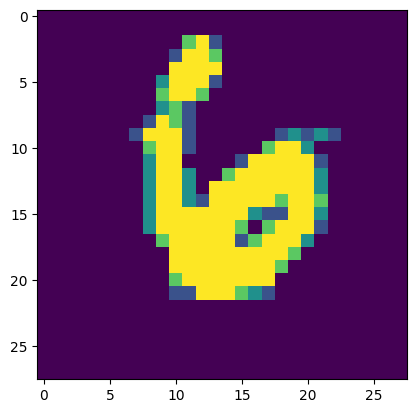

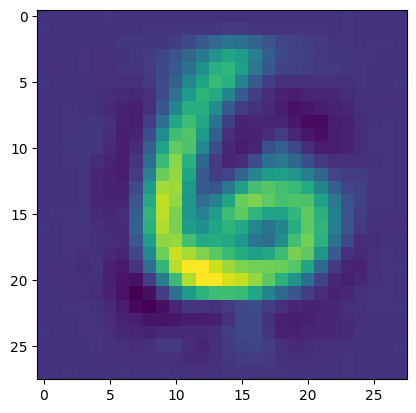

Iteration: 25000 | loss: 0.0411408394575119


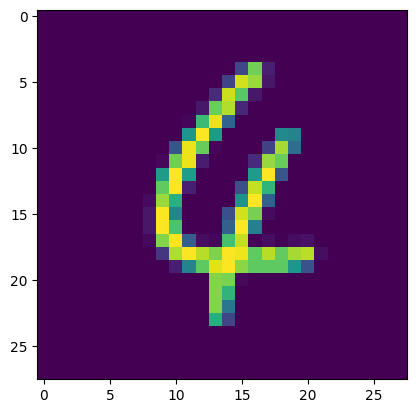

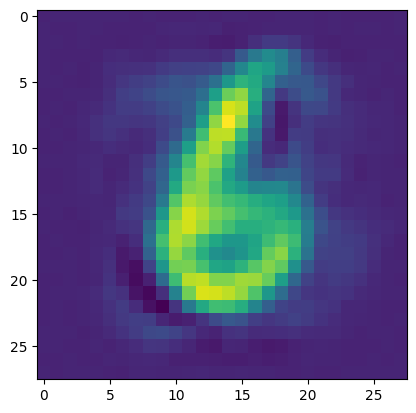

Iteration: 30000 | loss: 0.04125280678272247


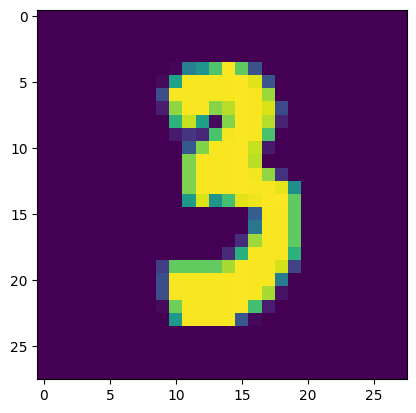

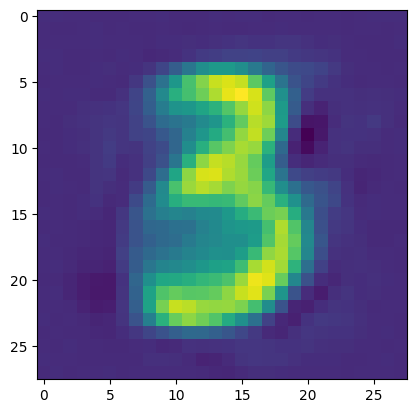

Iteration: 35000 | loss: 0.06798378378152847


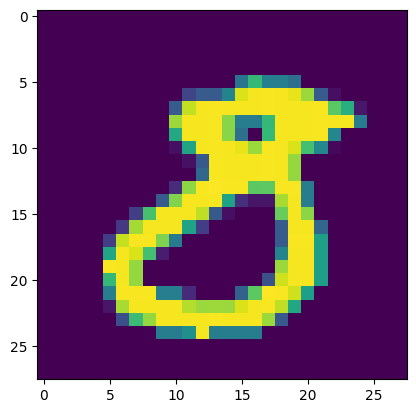

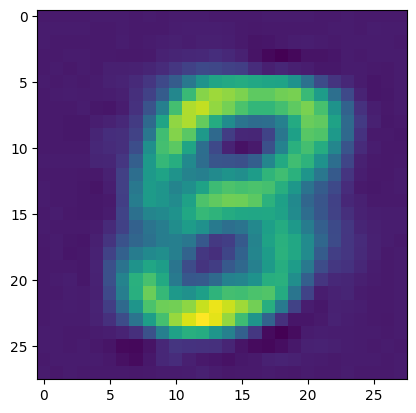

Iteration: 40000 | loss: 0.033157747238874435


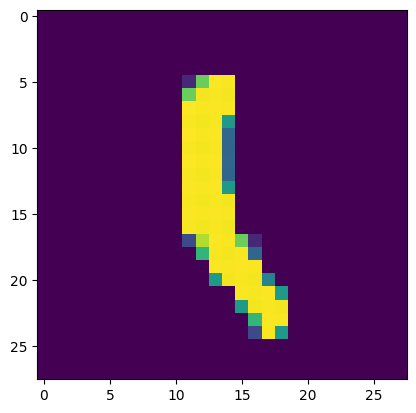

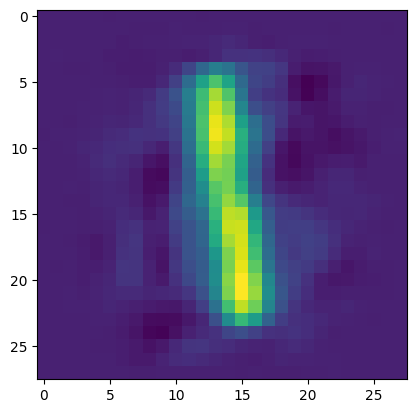

Iteration: 45000 | loss: 0.024407045915722847


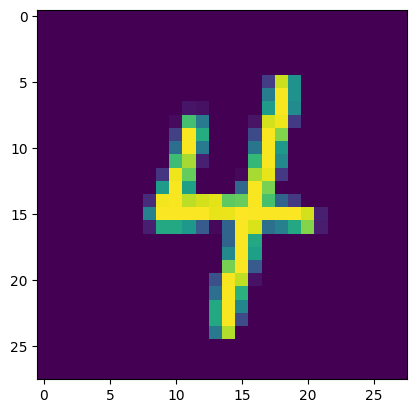

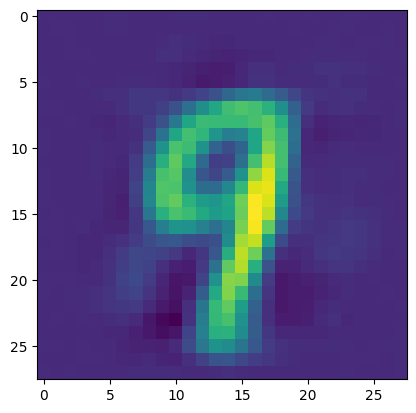

Iteration: 50000 | loss: 0.06487918645143509


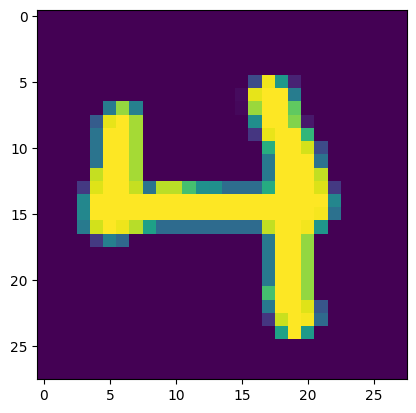

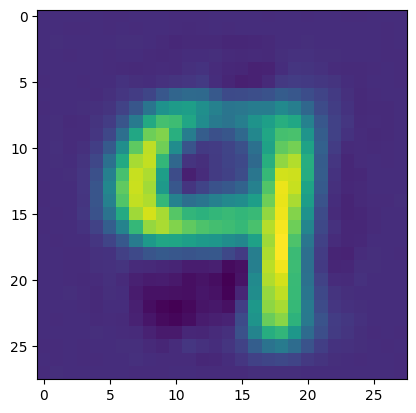

In [76]:
t = 0
for input, _ in train_data:

    opt.zero_grad()

    input_device = input.to(device)

    label_pred = model(input.to(input_device))

    loss = criterion(label_pred.flatten(), input_device)

    loss.backward()

    opt.step()

    t+=1

    if t%5000==0 or t==1:
        print(f"Iteration: {t} | loss: {loss.item()}")
        res = to_numpy(label_pred)
        plt.imshow(to_numpy(input))
        plt.show()
        plt.imshow(res)
        plt.show()

In [67]:
!mkdir models

In [77]:
torch.save(model, './models/AutoEncoder_Model_V3.pth')

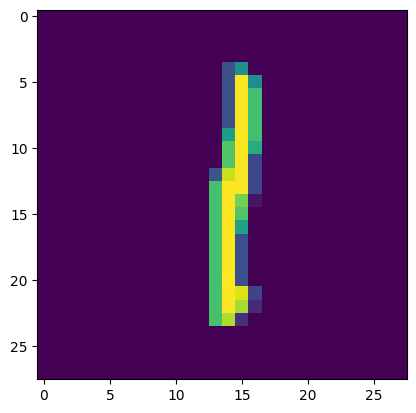

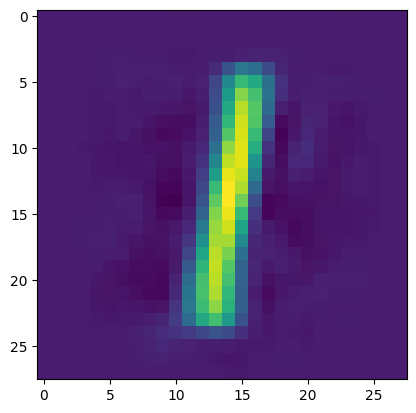

In [85]:
img = mnist[310][0]
out_img = model(img.to(device))

plt.imshow(to_numpy(img))
plt.show()
plt.imshow(to_numpy(out_img))

## Inference

### Encoder

In [95]:
# bring the encoder to CPU

encoder = model.encoder.cpu()

In [96]:
encoder

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=16, bias=True)
  (7): ReLU()
  (8): Linear(in_features=16, out_features=8, bias=True)
)

In [114]:
zeros = torch.stack(tuple(map(lambda x:x[0], filter(lambda x: x[1] == 0, mnist))))

In [115]:
zeros.shape

torch.Size([5923, 784])

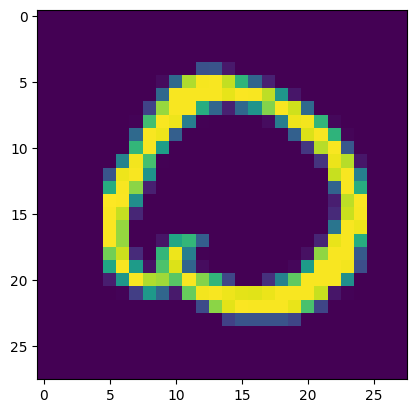

In [128]:
plt.imshow(to_numpy(zeros[100]))

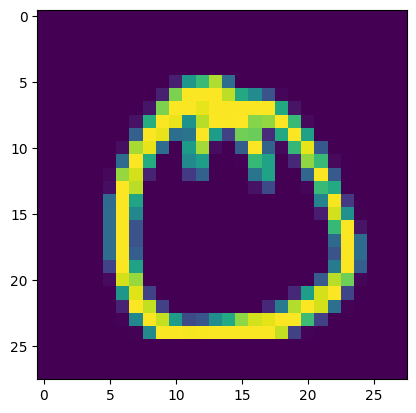

In [129]:
plt.imshow(to_numpy(zeros[1000]))

Now let define two images `img1` and `img2` and get their dense representation with the `Encoder` model. Then, calculate their similarity.

In [130]:
img1 = zeros[100]
img2 = zeros[1000]

In [131]:
img1_vec = encoder(img1)
img2_vec = encoder(img2)

In [132]:
img1_vec

tensor([-2.5971, 11.2957,  2.7505,  1.2234,  9.0701, -4.4578, 12.3511,  6.7155],
       grad_fn=<ViewBackward0>)

In [133]:
img2_vec

tensor([-1.7560,  6.6324,  1.6814,  1.0667,  5.5846, -2.9041,  7.6787,  4.3305],
       grad_fn=<ViewBackward0>)

In [134]:
def similarity_of(vec1: torch.Tensor, vec2: torch.Tensor):
  return torch.dot(vec1, vec2)/(vec1.norm()* vec2.norm())

In [136]:
# Get The similarity between two images

similarity_of(img1_vec, img2_vec)

tensor(0.9991, grad_fn=<DivBackward0>)

### Decoder

In [150]:
decoder = model.decoder.cpu()

In [143]:
def get_mean_std(encoder, digit_matrix: torch.Tensor):
  repr = encoder(digit_matrix)
  return repr.mean(axis=0), repr.std(axis=0)

In [159]:
mean, std = get_mean_std(encoder, zeros)

In [174]:
gen_repr_img = torch.normal(mean, std)

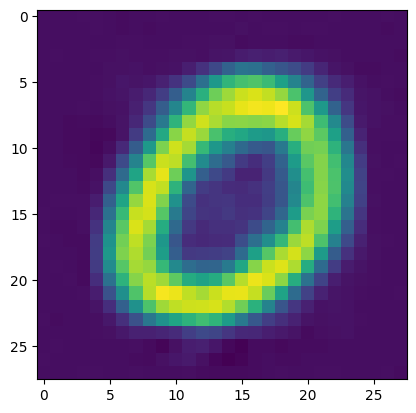

In [175]:
plt.imshow(to_numpy(decoder(gen_repr_img)))

> #### Woooow, this image doesn't exist. It's generated 🔥🔥🔥🔥🔥